In [3]:
import os
import yaml
import pytorch_lightning as pl
import torch
from torchvision import transforms
from torchvision.utils import save_image

from data_loaders_l import SynthesisDataModule
from models_l import CVAE

# Load configuration
with open('config_l.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Extract parameters from config
batch_size = config.get('batch_size', 1)  # use a small batch size for inference
latent_dim = config.get('latent_dim', 100)
label_dim = config.get('label_dim', 4)
experiment_name = config.get('experiment_name', 'default_experiment')
model_dir = config.get('model_dir', 'saved_models')

# Specify the checkpoint path to load the trained model from.
checkpoint_path = os.path.join(model_dir, 'cvae-epoch=30-val_loss=0.0000.ckpt')

# Set up the same transform as used during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)),  # Rescale to [0,1]
    transforms.Normalize((0.5,), (0.5,)),  # Normalize if desired (this will shift [0,1] to approx. [-1,1])
    transforms.Lambda(lambda x: x.to(torch.float32))
])


In [4]:
# Set up data module for inference
data_module = SynthesisDataModule(batch_size=batch_size, transform=transform)
data_module.setup()

# Load the trained model from checkpoint
model = CVAE.load_from_checkpoint(
    checkpoint_path,
    latent_dim=latent_dim,
    label_dim=label_dim,
    learning_rate=0  # learning_rate is not used during inference
)
model.eval()  # Set model to evaluation mode

# Create a directory to save inference results
inference_dir = os.path.join('inference_results', experiment_name)
os.makedirs(inference_dir, exist_ok=True)

# Choose which dataloader to use for inference. 
# If you don't have a separate test set, you can use the train or validation dataloader.
dataloader = data_module.test_dataloader()

tensor([[[[4.7494e-06, 5.2244e-07, 2.7622e-07,  ..., 2.3880e-06,
           9.9347e-07, 4.0842e-06],
          [3.0157e-07, 8.0226e-10, 1.5106e-07,  ..., 8.4953e-10,
           3.9919e-08, 4.9069e-06],
          [8.3722e-10, 3.0741e-11, 8.1457e-12,  ..., 2.2627e-09,
           6.5531e-14, 7.5668e-07],
          ...,
          [3.6506e-07, 3.0334e-09, 1.6152e-09,  ..., 7.0342e-11,
           3.1483e-10, 5.5578e-08],
          [3.0154e-07, 2.2015e-07, 4.9800e-10,  ..., 1.7017e-09,
           6.8145e-11, 3.7872e-07],
          [2.2072e-06, 7.2111e-07, 3.6591e-08,  ..., 8.2671e-07,
           4.8313e-07, 3.5210e-06]]],


        [[[4.6700e-06, 3.3619e-07, 2.7636e-07,  ..., 2.4062e-06,
           1.1440e-06, 4.6390e-06],
          [3.0099e-07, 7.9206e-10, 8.6445e-08,  ..., 4.3520e-10,
           3.4471e-08, 5.0272e-06],
          [6.8905e-10, 3.0465e-11, 5.7161e-12,  ..., 2.3101e-09,
           8.4192e-14, 8.7191e-07],
          ...,
          [2.9666e-07, 3.5121e-09, 8.3627e-10,  ..., 2.68

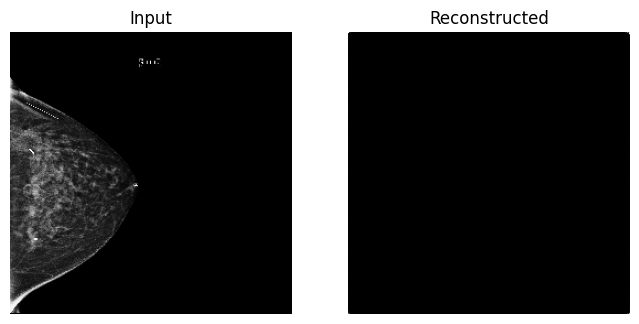

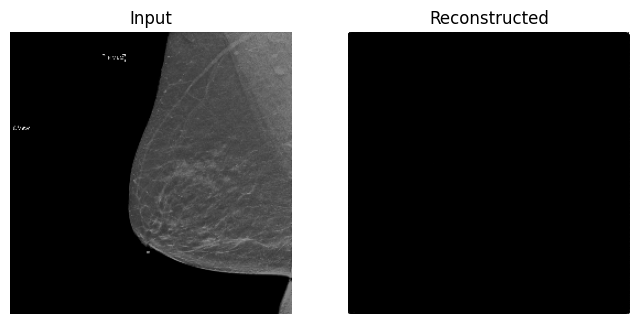

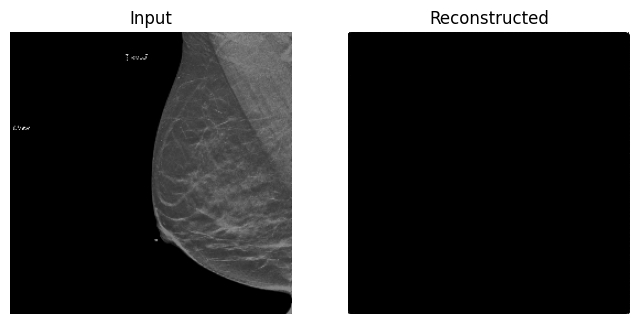

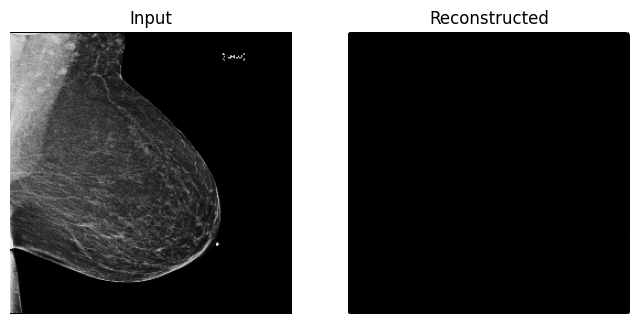

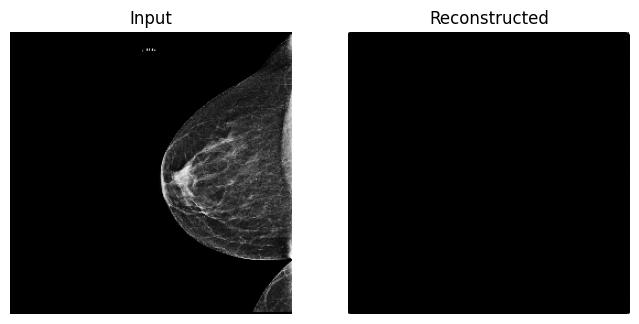

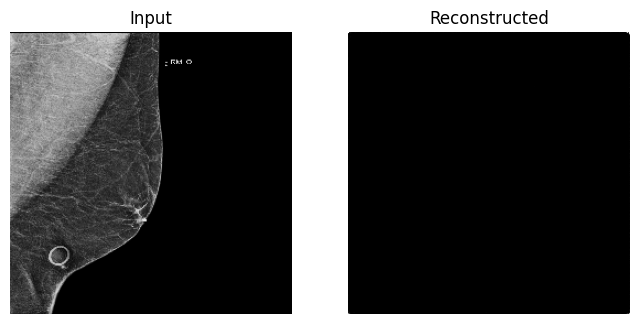

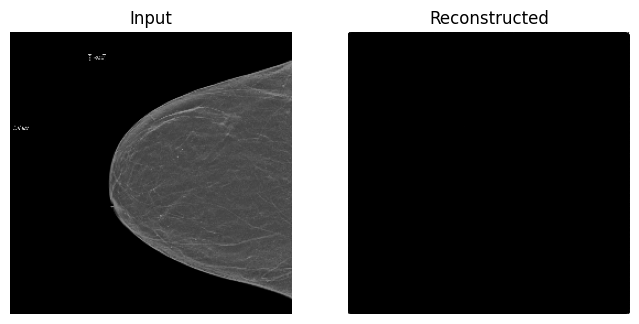

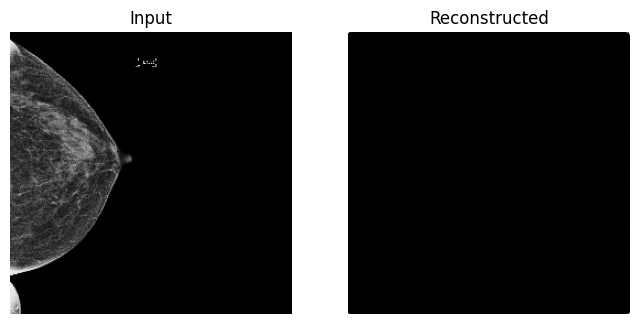

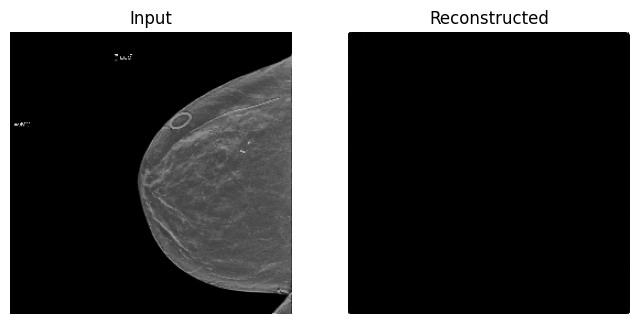

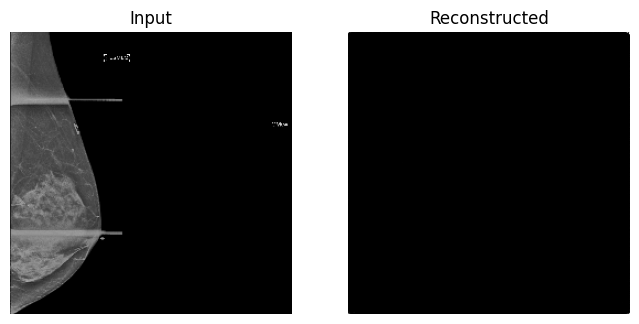

Inference complete!


In [8]:
import matplotlib.pyplot as plt

# Determine the device the model is on
device = next(model.parameters()).device

num_images_to_show = 10
images_shown = 0

with torch.no_grad():
    for i, (imgs, labels) in enumerate(dataloader):
        # Move the inputs to the same device as the model
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Generate reconstruction using the trained model
        reconstructed, mu, logvar, z = model(imgs, labels)

        print(reconstructed)
        
        # Iterate over each image in the batch
        for j in range(imgs.size(0)):
            if images_shown >= num_images_to_show:
                break
            
            # Convert tensors to CPU and remove extra dimensions (assuming grayscale images)
            input_img = imgs[j].cpu().squeeze()
            rec_img = reconstructed[j].cpu().squeeze()
            
            # Plot input and reconstructed images side by side
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].imshow(input_img, cmap='gray')
            axs[0].set_title("Input")
            axs[0].axis('off')
            axs[1].imshow(rec_img, cmap='gray')
            axs[1].set_title("Reconstructed")
            axs[1].axis('off')
            plt.show()
            
            images_shown += 1
        
        if images_shown >= num_images_to_show:
            break

print("Inference complete!")
